In [1]:
from math import pi, cos, sin, sqrt
from pprint import pprint

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.linalg as LA

import open3d as o3d
import matplotlib.pyplot as plt

from tqdm import tqdm


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
np.set_printoptions(suppress=True)


# 1 Rotation

## helper functions

In [3]:
def skew2vec(x_hat: np.ndarray) -> np.ndarray:
    """
    hat map so3 to vector
    :param x_hat:
    :return (3,) vector
    """
    assert x_hat.shape == (3, 3), "x_hat must be a 3x3 matrix"
    x1, x2, x3 = x_hat[2, 1], x_hat[0, 2], x_hat[1, 0]
    return np.array([x1, x2, x3])


def vec2skew(x: np.ndarray) -> np.ndarray:
    """
    vector to hat map so3
     [[0, -x3, x2],
      [x3, 0, -x1],
      [-x2, x1, 0]]
    :param x: vector
    :type x: numpy array vector
    :return: skew symmetric matrix
    """
    assert x.size == 3, "x must be a vector with 3 elements"
    x_hat = np.zeros((3, 3), dtype=np.float64)
    x_hat[0, 1] = -x[2]
    x_hat[0, 2] = x[1]
    x_hat[1, 0] = x[2]
    x_hat[1, 2] = -x[0]
    x_hat[2, 0] = -x[1]
    x_hat[2, 1] = x[0]

    return x_hat


def get_qs_qv_from_Quat(quat: np.ndarray):
    """Extract qs and qv from quaternion"""
    assert quat.size == 4, "q must be a quaternion with 4 elements"
    qs = quat[0]
    qv = quat[1:]
    return qs, qv


def get_rotation_matrix_from_Quat(quat: np.ndarray):
    assert quat.size == 4, "q must be a quaternion with 4 elements"
    assert abs(LA.norm(quat) - 1) < 1e-6, "q must be a unit quaternion"
    I = np.eye(3)
    qs, qv = get_qs_qv_from_Quat(quat)
    qv = qv.reshape(3, 1)

    qv_skew = vec2skew(qv)
    a = qs * I + qv_skew
    b = qs * I - qv_skew

    Eq = np.hstack([-qv, a])
    Gq = np.hstack([-qv, b])
    return Eq @ Gq.T


def get_exponential_coordinate_from_Quat(quat: np.ndarray):
    """
    return:
        omega_hat: unit vector of rotation axis
        theta: angle of rotation
    """
    qs, qv = get_qs_qv_from_Quat(quat)

    # A more numerically stable expression of the rotation angle
    # theta = 2 * np.arccos(qs)
    theta = 2 * np.arctan2(LA.norm(qv), qs)

    if theta == 0:
        return theta, np.zeros_like(qv)
    omega_hat = qv / np.sin(theta / 2)
    assert abs(LA.norm(omega_hat) - 1) < 1e-6, "||w|| != 1"

    return omega_hat, theta


def get_rotation_matrix_from_axis_angle(omega_hat: np.ndarray, theta: float):
    """
    get rotation matrix from exp map
    R ∈ SO(3) := Rot(w,theta)
        = \exp^{[\hat{w}] \theta}
        = I + [w]sin(\theta) + [w]^2 (1-cos(\theta))
    :param omega_hat: unit vector of rotation axis
    :param theta: angle of rotation
    return: rotation matrix
    """
    assert LA.norm(omega_hat) == 1, "omega_hat must be a unit vector"

    omega_hat_skew = vec2skew(omega_hat)

    # Rodrigues Formula
    rot = (
        np.eye(3)
        + omega_hat_skew * np.sin(theta)
        + LA.fractional_matrix_power(omega_hat_skew, 2) * (1 - np.cos(theta))
    )

    test = o3d.geometry.get_rotation_matrix_from_axis_angle(omega_hat * theta)
    assert np.allclose(rot, LA.expm(omega_hat_skew * theta)), "exp map is not correct"
    assert np.allclose(rot, test), "rotation matrix is not correct"
    return rot

def hw0_solve(A, b, eps):
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    # case 1
    if x.T @ x < eps:
        return x
    # case 2
    d, U = np.linalg.eigh(A.T@A) # SVD of A may be faster
    k = U.T@(A.T@b)
    def func(lam):
        return ((k / (d + 2 * lam))**2).sum() - eps
    def dfunc(lam):
        return -4 * ((k**2 / (d+2*lam)**3)).sum()
    # Newton, should converge in less than 10 iterations
    lam = 0
    while True:
        lam2 = lam - func(lam) / dfunc(lam)
        if abs(lam-lam2) < 1e-6:
            break
        lam = lam2
    x = U@(np.diag(1/(d + 2 * lam))@(U.T@(A.T@b)))
    return x



In [4]:
class rotation:
    def __init__(self) -> None:
        sqrt2 = np.sqrt(2)
        self.p = np.array([1 / sqrt2, 1 / sqrt2, 0, 0])
        self.q = np.array([1 / sqrt2, 0, 1 / sqrt2, 0])

    def Q1(self):
        # (1) ==============================================
        r = (self.q + self.p) / 2
        norm_r = LA.norm(r)
        print(f"norm of r: {norm_r}")

        # unit quaternion
        unit_r = r / norm_r
        assert abs(LA.norm(unit_r) - 1) < 1e-6, "r is not a unit quaternion"

        rot = o3d.geometry.get_rotation_matrix_from_quaternion(unit_r)

        M_r = get_rotation_matrix_from_Quat(unit_r)
        assert np.allclose(M_r, rot), "rotation matrix is not correct"
        print(f"M(r): ")
        pprint(M_r)

        omega_hat_r, theta_r = get_exponential_coordinate_from_Quat(unit_r)
        print(f"theta: {theta_r: .4f} in radians / {np.rad2deg(theta_r)} in degrees")
        print(f"omega_hat_r: {omega_hat_r}")


    def Q2(self):
        omega_hat_p, theta_p = get_exponential_coordinate_from_Quat(self.p)
        omega_hat_q, theta_q = get_exponential_coordinate_from_Quat(self.q)

        print(f"theta_p: {theta_p: .4f} in radians / {np.rad2deg(theta_p)} in degrees")
        print(f"omega_hat_p: {omega_hat_p}")
        print(f"exp coord: {theta_p * omega_hat_p}")
        
        print(f"theta_q: {theta_q: .4f} in radians / {np.rad2deg(theta_q)} in degrees")
        print(f"omega_hat_q: {omega_hat_q}")
        print(f"exp coord: {theta_q * omega_hat_q}")


    def Q3_a(self):
        omega_hat_p, theta_p = get_exponential_coordinate_from_Quat(self.p)
        omega_hat_q, theta_q = get_exponential_coordinate_from_Quat(self.q)

        R_p = get_rotation_matrix_from_axis_angle(omega_hat_p, theta_p)
        R_q = get_rotation_matrix_from_axis_angle(omega_hat_q, theta_q)
        print(f"R_p: ")
        pprint(R_p)
        print(f"R_q: ")
        pprint(R_q)


    def Q3_b(self):
        _, p_qv = get_qs_qv_from_Quat(self.p)
        _, q_qv = get_qs_qv_from_Quat(self.q)

        p_skew = vec2skew(p_qv)
        q_skew = vec2skew(q_qv)

        a = LA.expm(p_skew)
        b = LA.expm(q_skew)

        c = a @ b
        d = LA.expm(p_skew + q_skew)
        print(f"exp([w1] + [w2] = ")
        print(c)
        print(f"exp([w1]) exp([w2] = ")
        print(d)

        print(f"exp([w1] + [w2]) = exp([w1]) exp([w2]): {np.allclose(c, d)}")


    def Q4_a(self):
        p_prime = -self.p
        q_prime = -self.q

        """
        Two unit quaternions correspond to the same rotation
        R(q) = R(-q)
        """

        omega_hat_p, theta_p = get_exponential_coordinate_from_Quat(self.p)
        omega_hat_q, theta_q = get_exponential_coordinate_from_Quat(self.q)
        omega_hat_p_prime, theta_p_prime = get_exponential_coordinate_from_Quat(p_prime)
        omega_hat_q_prime, theta_q_prime = get_exponential_coordinate_from_Quat(q_prime)

        print(f"theta_p: {theta_p: .4f} in radians / {np.rad2deg(theta_p)} in degrees")
        print(f"omega_hat_p: {omega_hat_p}")
        print(
            f"theta_p': {theta_p_prime: .4f} in radians / {np.rad2deg(theta_p_prime)} in degrees"
        )
        print(f"omega_hat_p': {omega_hat_p_prime}")

        print(
            f"equal rotation: {np.allclose(get_rotation_matrix_from_Quat(self.p), get_rotation_matrix_from_Quat(p_prime))}"
        )

        print("-" * 50)
        print(f"theta_q: {theta_q: .4f} in radians / {np.rad2deg(theta_q)} in degrees")
        print(f"omega_hat_q: {omega_hat_q}")
        print(
            f"theta_q': {theta_q_prime: .4f} in radians / {np.rad2deg(theta_q_prime)} in degrees"
        )
        print(f"omega_hat_q': {omega_hat_q_prime}")
        print(
            f"equal rotation: {np.allclose(get_rotation_matrix_from_Quat(self.q), get_rotation_matrix_from_Quat(q_prime))}"
        )

In [5]:
rot_ans = rotation()

## 1.1 
### Find a quaternion $r$ that is a scalar multiple of $(p + q)/2$ and that has unit norm, $|r| = 1$, and calculate the rotation matrix $M (r)$. Around what axis does $M (r)$ rotate, and through what angle

In [6]:
rot_ans.Q1()

norm of r: 0.8660254037844386
M(r): 
array([[ 0.66666667,  0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667, -0.66666667],
       [-0.66666667,  0.66666667,  0.33333333]])
theta:  1.2310 in radians / 70.52877936550931 in degrees
omega_hat_r: [0.70710678 0.70710678 0.        ]


## 1.2 What are the exponential coordinates of $p$ and $q$?

In [7]:
rot_ans.Q2()

theta_p:  1.5708 in radians / 90.0 in degrees
omega_hat_p: [1. 0. 0.]
exp coord: [1.57079633 0.         0.        ]
theta_q:  1.5708 in radians / 90.0 in degrees
omega_hat_q: [0. 1. 0.]
exp coord: [0.         1.57079633 0.        ]


## 1.3.a  Build the skew-symmetric matrix $[\omega_p]$ of $p$ and $[\omega_q]$ of $q$, and derive their rotation matrices.

In [8]:
rot_ans.Q3_a()

R_p: 
array([[ 1.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  1.,  0.]])
R_q: 
array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [-1.,  0.,  0.]])


## 1.3.b 

verify $$ \exp([\omega_1] + [\omega_2]) \neq \exp([\omega_1]) \exp([\omega_1]) $$

In [9]:
rot_ans.Q3_b()

exp([w1] + [w2] = 
[[ 0.7602446   0.          0.64963694]
 [ 0.42202815  0.7602446  -0.49388297]
 [-0.49388297  0.64963694  0.57797185]]
exp([w1]) exp([w2] = 
[[ 0.77015115  0.22984885  0.59500984]
 [ 0.22984885  0.77015115 -0.59500984]
 [-0.59500984  0.59500984  0.54030231]]
exp([w1] + [w2]) = exp([w1]) exp([w2]): False


## 1.3.c


In [10]:
# Note Matplotlib is only suitable for simple 3D visualization.
# For later problems, you should not use Matplotlib to do the plotting

def show_points(points):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points[0], points[2], points[1])
    
def compare_points(points1, points2):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points1[0], points1[2], points1[1])
    ax.scatter(points2[0], points2[2], points2[1])    

Since $R_2 = R 1 \exp([\Delta w]) \approx R_1 (I + [\Delta w])$ for $\Delta w \approx 0$.

$$ 
\argmin || R x_i - y_i  ||_{F}^2 \\
= \argmin || R' (I + [\Delta w]) x_i - y_i  ||_{F}^2 \\
= \argmin || R' [\Delta w] x_i  + R' xi - y_i  ||_{F}^2\\
= \argmin || R' (\Delta w \times x_i)  + R' xi - y_i  ||_{F}^2\\
= \argmin || -R' x_i \times \Delta w   + R' xi - y_i  ||_{F}^2\\
= \argmin || -R' x_i \times \Delta w   + R' xi - y_i  ||_{F}^2\\
= \argmin || -R' [x_i] \Delta w   + R' xi - y_i  ||_{F}^2\\
$$
$$
= ||-\begin{bmatrix}
R' [x_1] \\
R' [x_2] \\
...\\
R' [x_n] \\

\end{bmatrix} \Delta w +  \begin{bmatrix}
R' x_1 - y_1 \\
R' x_2 - y_2 \\
... \\
R' x_n - y_n \\
\end{bmatrix}||_{F}^2
$$

Convert the objective to a linear least square problem.

$$ \min_{R} ||A \Delta w - B||^2_{F} $$

$$
A = -\begin{bmatrix}
R' [x_1] \\
R' [x_2] \\
...\\
R' [x_n] \\

\end{bmatrix} 
$$

$$
B = -\begin{bmatrix}
y_1 -R' x_1   \\
y_2 - R' x_2   \\
... \\
y_n - R' x_n   \\
\end{bmatrix}
$$

In [11]:
npz = np.load('data/HW1_P1.npz')
X = npz['X']
Y = npz['Y']
# compare_points(X, Y)  # noisy teapotsand
X.shape, Y.shape

((3, 2000), (3, 2000))

In [12]:
def calcuA(R, X):
    A = R @ vec2skew(X[:, 0])
    for i in range(1, X.shape[1]):
        b = R @ vec2skew(X[:, i])
        A = np.vstack((A, b))
    return -A


def calcuB(R, X, Y):    
    B = (R @ X[:, 0] - Y[:, 0]).reshape(3, 1)
    for i in range(1, X.shape[1]):
        b = (R @ X[:, i] - Y[:, i]).reshape(3, 1)
        B = np.vstack((B, b))
    return -B

In [16]:
 # implementation of Q3
I = np.eye(3)
R = np.eye(3)
old_R = R.copy()
# solve this problem here, and store your final results in R1

for i in tqdm(range(100)):
    A = calcuA(R, X)
    B = calcuB(R, X, Y)
    
    delta_w = hw0_solve(A, B, eps=1)
    R = R @ LA.expm(vec2skew(delta_w))
    np.testing.assert_allclose (R.T@R, I, rtol=1e-05, atol=1e-08)
    
    if np.allclose(R, old_R):
        print("converged at iteration {}".format(i))
        break
    old_R = R.copy()

  7%|▋         | 7/100 [00:00<00:03, 29.87it/s]

converged at iteration 7


array([[ 1.,  0., -0.],
       [ 0.,  1.,  0.],
       [-0.,  0.,  1.]])

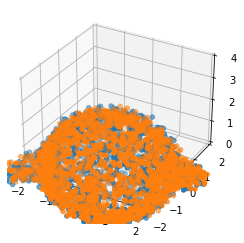

In [17]:
# Testing code, you should see the points of the 2 teapots roughly overlap
compare_points(R@X, Y)
R.T@R

### 1.4.a Double-covering of quaternions 


In [18]:
rot_ans.Q4_a()


theta_p:  1.5708 in radians / 90.0 in degrees
omega_hat_p: [1. 0. 0.]
theta_p':  4.7124 in radians / 270.0 in degrees
omega_hat_p': [-1. -0. -0.]
equal rotation: True
--------------------------------------------------
theta_q:  1.5708 in radians / 90.0 in degrees
omega_hat_q: [0. 1. 0.]
theta_q':  4.7124 in radians / 270.0 in degrees
omega_hat_q': [-0. -1. -0.]
equal rotation: True


1.4.b your solution here

---------------------------------------------------------------------------------------

# 2 Geometry

## 2.1

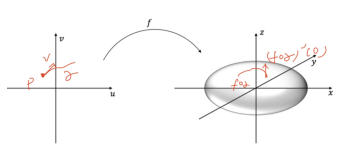

In [19]:
ans = plt.imread('./2.1.png')
plt.imshow(ans)
plt.axis('off')
plt.show()

In [20]:
a, b, c = 1, 1, 0.5

### Helper functions

In [21]:
# These are some convenient functions to create open3d geometries and plot them
# The viewing direction is fine-tuned for this problem, you should not change them
import open3d
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

vis = open3d.visualization.Visualizer()
vis.create_window(visible = False)

def draw_geometries(geoms):
    for g in geoms:
        vis.add_geometry(g)
    view_ctl = vis.get_view_control()
    view_ctl.set_up((0, 1e-4, 1))
    view_ctl.set_front((0, 0.5, 2))
    view_ctl.set_lookat((0, 0, 0))
    # do not change this view point
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(True)
    plt.figure(figsize=(8,6))
    plt.imshow(np.asarray(img)[::-1, ::-1])
    for g in geoms:
        vis.remove_geometry(g)
    
def create_arrow_from_vector(origin, vector, color = [1, 0, 1]):
    '''
    origin: origin of the arrow
    vector: direction of the arrow
    '''
    v = np.array(vector)
    v /= np.linalg.norm(v)
    z = np.array([0,0,1])
    angle = np.arccos(z@v)
    
    arrow = open3d.geometry.TriangleMesh.create_arrow(0.05, 0.1, 0.25, 0.2)
    arrow.paint_uniform_color(color)
    T = np.eye(4)
    T[:3, 3] = np.array(origin)
    T[:3,:3] = open3d.geometry.get_rotation_matrix_from_axis_angle(np.cross(z, v) * angle)
    arrow.transform(T)
    return arrow

def create_ellipsoid(a,b,c):
    sphere = open3d.geometry.TriangleMesh.create_sphere()
    sphere.transform(np.diag([a,b,c,1]))
    sphere.compute_vertex_normals()
    return sphere


def create_lines(points):
    lines = []
    for p1, p2 in zip(points[:-1], points[1:]):
        height = np.linalg.norm(p2-p1)
        center = (p1+p2) / 2
        d = p2-p1
        d /= np.linalg.norm(d)
        axis = np.cross(np.array([0,0,1]), d)
        axis /= np.linalg.norm(axis)
        angle = np.arccos(np.array([0,0,1]) @ d)
        R = open3d.geometry.get_rotation_matrix_from_axis_angle(axis * angle)
        
        T = np.eye(4)
        T[:3,:3]=R
        T[:3,3] = center
        cylinder = open3d.geometry.TriangleMesh.create_cylinder(0.02, height)
        cylinder.transform(T)
        cylinder.paint_uniform_color([1,0,0])
        lines.append(cylinder)
    return lines

In [22]:
# example code to draw ellipsoid, curve, and arrows
arrow = create_arrow_from_vector([0.,0.,1.], [1.,1.,0.])
ellipsoid = create_ellipsoid(a, b, c)
cf = open3d.geometry.TriangleMesh.create_coordinate_frame()
cf.scale(1.5, (0,0,0))
curve = create_lines(np.array([[1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1], [1,1,1]], dtype=np.float64))
# draw_geometries([ellipsoid, cf, arrow] + curve)
geoms = [ellipsoid, cf, arrow] + curve


In [23]:

colormap = {
    "red": [1, 0, 0],
    "green": [0, 1, 0],
    "blue": [0, 0, 1],
    "orange": [1, 0.706, 0],
    "yellow": [1, 1, 0],
    "black": [0, 0, 0],
    "white": [1, 1, 1],
}

## 2.2 

In [24]:
def f(u, v):
    "map f : R2 -> R3 | (u,v) to (x,y,z)"
    assert -pi < u < pi
    assert 0 < v < pi
    return np.array([
        [a * np.cos(u) * np.sin(v)],
        [b * np.sin(u) * np.sin(v)],
        [c * np.cos(v)],
    ])


def gamma(t):
    """
    Parameterized Curves
    """
    u = pi / 4
    v = pi / 6
    return t + u, v


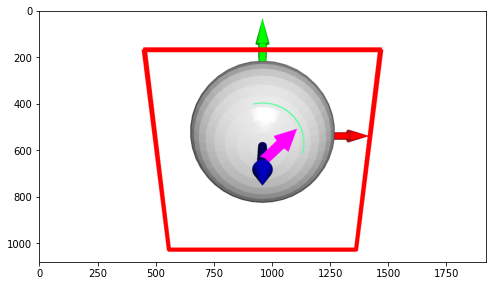

In [25]:
p = np.array([pi / 4, pi / 6])

# t \in [-1, 1]
time_steps = np.arange(-1, 1, 0.01)
gamma_t = np.array([gamma(t) for t in time_steps])
                    
curve2D = np.vstack([p, gamma_t])

f_curve3D = np.asarray([f(u, v).ravel() for u, v in curve2D])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(f_curve3D)

draw_geometries(geoms + [pcd])

---------------------------------------------------------------------------------------

### 2.3.a 
What is $Df_p$? Express it as a matrix.





$$\begin{bmatrix}
-a \sin (u) \sin (v) & a \cos (u) \cos (v) \\
b\cos (u) \sin (v) & b \sin (u) \cos (v) \\
0 & -c \sin (v) \\
\end{bmatrix} $$


In [26]:
def get_D_fp(u, v):
    """
    Df_p: T_p(R^2) -> T_{f(p)}R^3
    """
    a, b, c = 1, 1, 0.5
    return np.array(
        [
            [-a * np.sin(u) * np.sin(v), a * np.cos(u) * np.cos(v)],
            [b * np.cos(u) * np.sin(v), b * np.sin(u) * np.cos(v)],
            [0, -c * np.sin(v)],
        ]
    )


### 2.3.b Describe the geometric meaning of $Df_p$

It maps or relate a vector in tangent space ($T_{p}$) of the domain $U$ to the tangent space of the surface $T_{f(p)}$.


### 2.3.c  Draw $Df_p (v)$ on the ellipsoid when $p = (\pi/4 , \pi/6 )$ and $v = (1, 0)$.

In [27]:
def flatten2list(arr):
    return arr.flatten().tolist()

In [28]:
p = [pi/4, pi/6]

v = np.array([1, 0]).reshape(2, 1)

Dfp_v = get_D_fp(*p) @ v
Dfp_v

array([[-0.35355339],
       [ 0.35355339],
       [ 0.        ]])

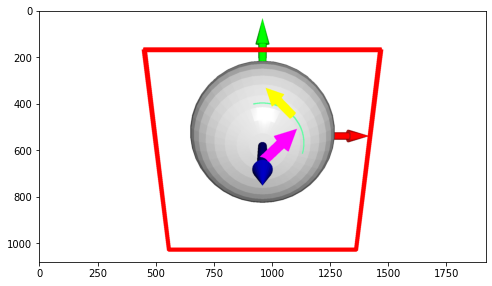

In [29]:
# start point
fp = f(*p).flatten()
Dfpv_arrow = create_arrow_from_vector(flatten2list(fp), flatten2list(Dfp_v), color=colormap["yellow"])
geoms_with_arrow = geoms + [Dfpv_arrow]
draw_geometries(geoms_with_arrow + [pcd])


#### 2.3.d What is the normal vector of the tangent plane at $p$?

$$f_u := \frac{\partial{f}}{\partial {u}}, f_v := \frac{\partial{f}}{\partial {v}}$$

$$N = \frac{f_u \times f_v}{||f_u \times f_v||}$$

where
$$ f_u \times f_v = \begin{bmatrix}
-bc \cos (u) \sin^2 (v) \\
-ac \sin (u) \sin^2 (v) \\
-2ab\cos (v) \sin (v)\\
\end{bmatrix} $$

$$ ||f_u \times f_v|| = \sqrt{ (bc \cos (u) \sin^2 (v))^2 + (ac \sin (u) \sin^2 (v))^2 + (2ab\cos (v) \sin (v))^2} $$

### 2.3.e Give an orthonormal bases of the tangent space at $f (p)$ when $p = ( \pi/4 , \pi/6 )$.

$T_f(p)$ has orthonormal basis $[B, D_fp]$, where $B = Df_p \times N$ is the binormak vector.


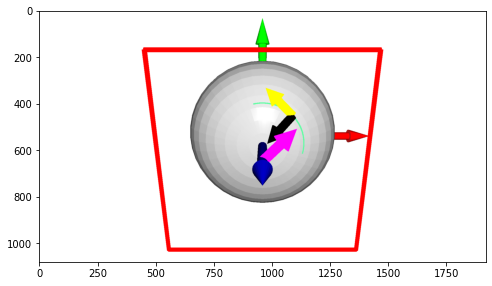

In [30]:
u, v = [pi / 4, pi / 6]
X = np.array([1, 0]).reshape(2, 1)
D_fp = get_D_fp(u, v)

f_u = D_fp[:, 0]
f_v = D_fp[:, 1]

N = np.cross(f_u, f_v)
N /= np.linalg.norm(N)

# binormal vector  
B = np.cross((D_fp@X).flatten(), N)
B /= np.linalg.norm(B)

B_arrow = create_arrow_from_vector(
    flatten2list(f(u, v)), flatten2list(B), color=colormap["black"]
)
geoms_with_surface_binormal = geoms + [B_arrow] + [pcd] + [Dfpv_arrow]
draw_geometries(geoms_with_surface_binormal)

--------------------------------------------------------------------------

## 2.4.a Given $p = ( \pi/ 4 , \pi/6 )$ and $v = (1, 0)$. For simplicity, let $g_v (t ) = ( f \odot \gamma)(t )$ denote the curve which passes through $p$ at $t = 0$.

What is the arc length $s(t)$ as the point moves from $g_v (0)$ to $g_v (t )$?

$$g_v'(t) = Df \cdot \gamma '(t)$$

$$ s(t) = \int_{0}^{t} ||g_v'(t)|| dt \\
    =  \int_{0}^{t} ||Df \cdot \gamma '(t)|| dt \\
    =  \int_{0}^{t} ||Df \cdot v|| dt
$$

$$ s(t) =\int_{0}^{t} || \begin{bmatrix} 

-a \sin (u) \sin (v) \\
b  \cos (u) \sin (v) \\
0 \\

\end{bmatrix}|| \\

= \int_{0}^{t} \sqrt{a^2 \sin^2 (u) \sin^2 (v) + b^2 \cos^2(u) \sin^2 (v)} \\

= \sqrt{a^2 \sin^2 (u) \sin^2 (v) + b^2 \cos^2(u) \sin^2 (v)} \cdot t \\

= \sqrt{[\sin^2 (u) + \cos^2(u)] \sin^2 (v)} \cdot t \\

= |\sin (v)| \cdot t \\

$$

Plug in $v = \pi/6$

$$s(t) = \frac{t}{2} $$

$$ t(s) = 2s $$



### 2.4.b Give the arc-length parameterization $h_v (s)$ of the curve $f \odot γ$.

since $s = t/2 \Rightarrow t = 2s$,

$$ h_v(s) = f \odot \gamma (2s) \\

= f \odot [2s + \pi/4, \pi/6] \\

= \begin{bmatrix}
a \cos(2s+\pi/4) \sin(\pi/6) \\
b \sin(2s+\pi/4) \sin(\pi/6) \\
c \cos(\pi/6) \\
\end{bmatrix}

$$

2.4.c

----------------------------------------

## 2.5

### 2.5.a
Compute the differential of the normal $ DN_p$

$$ DN_p = \begin{bmatrix}
\frac{\partial{N}}{\partial{u}} & \frac{\partial{N}}{\partial{v}} \\
\end{bmatrix}
= 
\begin{bmatrix}

bc \sin(u) \sin^2(v)& -2bc \cos(u) \sin(v) \cos(v)    \\
-ac\cos(u)\sin^2(v) & -2ac \sin(u) \sin(v)\ cos(v)   \\
0                   &  2ab (\sin^2(v) - \cos^2 (v))   \\
\end{bmatrix} $$

Plug in $a = 1$, $b = 1$, $c = 1$ 
$$ DN_p = \begin{bmatrix}

0.5 \sin(u) \sin^2(v)& - \cos(u) \sin(v) \cos(v)    \\
-0.5\cos(u)\sin^2(v) & - \sin(u) \sin(v)\ cos(v)   \\
0                   &  2 (\sin^2(v) - \cos^2 (v))   \\
\end{bmatrix} $$




$$\frac{\partial{N}}{\partial{u}} = 

\begin{bmatrix}


\frac{0.5\sin(u) \sin^2(v)} {\sqrt{0.25 sin^4(v) + 4 \sin^2(v)\cos^2(v)}} \\

\frac{0.5 \cos(u) \sin^2(u)} {\sqrt{0.25 sin^4(v) + 4 \sin^2(v)\cos^2(v)}} \\

0 \\

\end{bmatrix} $$


$$ \frac{\partial{N}}{\partial{v}}= \begin{bmatrix}

\frac{-0.5 \cos (u) \sin (v) \cos (v)}{(1-0.9375\sin^2(v)) (\sqrt{0.25 sin^4(v) + 4 \sin^2(v)\cos^2(v)})}\\


\frac{-0.5 \sin (u) \sin (v) \cos (v)}{(1-0.9375\sin^2(v)) (\sqrt{0.25 sin^4(v) + 4 \sin^2(v)\cos^2(v)})}\\


\frac{\sin^4(v) + \sin^2(v)\cos^2(v)}{(1-0.9375\sin^2(v)) (\sqrt{0.25 sin^4(v) + 4 \sin^2(v)\cos^2(v)})}\\


\end{bmatrix}
$$

In [31]:
def get_D_Np(u, v):
    
    denumerator_u = sqrt(0.25 * sin(v)**4 + 4 * sin(v)**2 * cos(v) **2)
    
    dN_du = np.array([
        [0.5 * sin(u) * sin(v)**2 ],
        [0.5 * cos(u) * sin(u)**2 ],
        [0], 
    ])
    dN_du /= denumerator_u
    
    
    denumerator_v = (1 - 0.9375 *sin(v)**2) * sqrt(0.25 * sin(v)**4 + 4 * sin(v)**2 *cos(v)**2)
    
    dN_dv = np.array([
        [-0.5* cos(u) * sin (v) *cos (v)],
        [-0.5* sin(u) * sin (v) *cos (v)],
        [sin(v)**4 + sin(v)*2 *cos(v)**2],
    ])
    
    dN_dv /= denumerator_v
     
    return np.hstack([dN_du, dN_dv])

### 2.5.b

2.5.c

In [32]:
p = [pi / 4, pi / 6]

D_fp = get_D_fp(*p)

D_Np = get_D_Np(*p)
D_Np, D_fp

(array([[ 0.10101525, -0.22852382],
        [ 0.20203051, -0.22852382],
        [ 0.        ,  1.21282799]]),
 array([[-0.35355339,  0.61237244],
        [ 0.35355339,  0.61237244],
        [ 0.        , -0.25      ]]))

In [33]:
# D_fp * S = D_Np 


S, res, rank, s = np.linalg.lstsq(D_fp, D_Np, rcond=None)
print(S)


[[ 0.14285714  0.        ]
 [ 0.2284023  -0.7176497 ]]


In [34]:
eigval, eigvec = LA.eig(S)

eigval, eigvec

(array([-0.7176497 +0.j,  0.14285714+0.j]),
 array([[0.        , 0.96653244],
        [1.        , 0.25654443]]))

In [35]:
x = f(u,v).tolist()

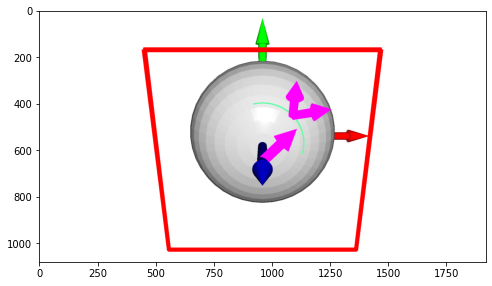

In [36]:
k1_arrow = create_arrow_from_vector(
    flatten2list(f(u, v)), flatten2list(eigvec[:, 1]) + x[-1], #color=colormap["orange"]
)
k2_arrow = create_arrow_from_vector(
    flatten2list(f(u, v)), flatten2list(eigvec[:, 0])+ x[-1], #color=colormap["orange"]
)

geoms_with_k1k2 = geoms +  [pcd] + [k1_arrow] + [k2_arrow]
draw_geometries(geoms_with_k1k2)

### 2.5.d Briefly describe the direction of the principal curvatures.
Direction of the principal curvatures are orthogonal to each other, and independent of parameterization.

# 3 Mesh

3.1 your proof here

3.2 your proof here

## 3.3 your solution here

In [37]:
# %reset -f

# You may want to restart your notebook here, to reinitialize Open3D
import open3d
import numpy as np
import matplotlib.pyplot as plt

vis = open3d.visualization.Visualizer()
vis.create_window(visible = False)

# Make sure you call this function to draw the points for proper viewing direction
def draw_geometries(geoms):
    for g in geoms:
        vis.add_geometry(g)
    view_ctl = vis.get_view_control()
    view_ctl.set_up((0, 1, 0))
    view_ctl.set_front((0, 2, 1))
    view_ctl.set_lookat((0, 0, 0))
    view_ctl.set_zoom(1)
    # do not change this view point
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(True)
    plt.figure(figsize=(8,6))
    plt.imshow(np.asarray(img))
    for g in geoms:
        vis.remove_geometry(g)

In [38]:
import trimesh
sievert_mesh = trimesh.load('./data/sievert.obj')
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(sievert_mesh.vertices)


In [39]:
import CalculCurvature as CC
# Calculate Rusinkiewicz estimation of mean and gauss curvatures
PrincipalCurvatures, PrincipalDir1, PrincipalDir2 = CC.GetCurvaturesAndDerivatives(sievert_mesh)


Calculating vertex normals .... Please wait
Finished calculating vertex normals
Calculating curvature tensors ... Please wait


In [ ]:
pcd1 = open3d.geometry.PointCloud()
pcd1.points = open3d.utility.Vector3dVector(PrincipalDir1)

pcd2 = open3d.geometry.PointCloud()
pcd2.points = open3d.utility.Vector3dVector(PrincipalDir2)


# draw_geometries([pcd]+[pcd1]+[pcd2])
draw_geometries([pcd])

plt.title("Sievert's surface")
plt.show()

In [ ]:
draw_geometries([pcd1])

In [ ]:
draw_geometries([pcd2])

$Df = [\xi_{u}, \xi_{v}]$

$S[Df]^{T} Y \approx [Df]^{T} \Delta{\vec{n}}$

e0 = n2 - n1

e1 = n0 - n2

e2 = n1 - n0

In [ ]:
# "Get all the edge vectors"
# e0 = np.array(FV.vertices[FV.faces[:, 2], :] - FV.vertices[FV.faces[:, 1], :])
# e1 = np.array(FV.vertices[FV.faces[:, 0], :] - FV.vertices[FV.faces[:, 2], :])
# e2 = np.array(FV.vertices[FV.faces[:, 1], :] - FV.vertices[FV.faces[:, 0], :])

In [ ]:

# e0 /= np.linalg.norm(e0, axis=1, keepdims=True) 
# e1 /= np.linalg.norm(e1, axis=1, keepdims=True)
# e2 /= np.linalg.norm(e2, axis=1, keepdims=True)


In [ ]:
# icosphere_mesh = trimesh.load('./data/icosphere.obj')

# icosphere_mesh

In [ ]:
# pcd_sphere = open3d.geometry.PointCloud()
# pcd_sphere.points = open3d.utility.Vector3dVector(icosphere_mesh)
# draw_geometries([pcd_sphere])

3.4

# 4 Point Cloud

## 4.1 Sample 100K points uniformly on the surface.

In [ ]:
saddle_mesh = trimesh.load('./data/saddle.obj')

In [ ]:
samples, face_idx = trimesh.sample.sample_surface_even(saddle_mesh, count=100_000)
samples.shape

In [ ]:
pcd_samples = open3d.geometry.PointCloud()
pcd_samples.points = open3d.utility.Vector3dVector(np.asarray(samples))
draw_geometries([pcd_samples])


## 4.2 Use iterative farthest point sampling method to sample 4K points from the 100K uniform samples.

In [ ]:
def fps_downsample(points, n_samples):
    """
    points: [N, 3] point cloud
    n_samples: 
    """
    points = np.asarray(points)
    
    # Represent the points by their indices in points
    points_left = np.arange(points.shape[0], dtype='int') 

    # Initialise an array for the sampled indices
    sample_idxs = np.zeros(n_samples, dtype='int') 

    # Initialise distances to inf
    dists = np.ones_like(points_left) * float('inf') 

    # Select a point from points by its index, save it
    selected = np.random.choice(points_left, size=1, replace=False)
    sample_idxs[0] = points_left[selected.item()]

    # Delete selected 
    points_left = np.delete(points_left, selected) # [P - 1]

    # Iteratively select points for a maximum of n_samples
    for i in range(1, n_samples):
        # Find the distance to the last added point in selected
        # and all the others
        last_added = sample_idxs[i-1]
        
        dist_to_last_added_point = (
            (points[last_added] - points[points_left])**2).sum(-1) # [P - i]

        # updated distances
        dists[points_left] = np.minimum(dist_to_last_added_point, 
                                        dists[points_left]) # [P - i]

        # We want to pick the one that has the largest nearest neighbor
        # distance to the sampled points
        selected = np.argmax(dists[points_left])
        sample_idxs[i] = points_left[selected]

        # Update points_left
        points_left = np.delete(points_left, selected)

    return points[sample_idxs]

In [ ]:
selected_points = fps_downsample(samples, n_samples=4_000)
selected_points

In [ ]:
pcd_selected_samples = open3d.geometry.PointCloud()
pcd_selected_samples.points = open3d.utility.Vector3dVector(selected_points)
draw_geometries([pcd_selected_samples])

## 4.3 your solution here

In [ ]:
from sklearn.decomposition import PCA

pca =PCA()

pca.fit(selected_points)

## 4.4 your solution here

# 5 Course Feedback

1. How many hours did you spend on this homework?
2. How many hours did you spend on the course each week?
3. Do you have any course related feedback?
   
   For the Office Hours,  It will be much easier to understand if you write down your explanations in a piece of paper rather than vocally explain it. 
   